## install mujoco-py and D4RL

* **Restart Runtime** after running this block to complete D4RL setup


In [1]:

!sudo apt-get update
!sudo apt-get install gcc

!sudo apt-get build-dep mesa
!sudo apt-get install llvm-dev
!sudo apt-get install freeglut3 freeglut3-dev

!sudo apt-get install python3-dev

!sudo apt-get install build-essential

!sudo apt install curl git libgl1-mesa-dev libgl1-mesa-glx libglew-dev \
        libosmesa6-dev software-properties-common net-tools unzip vim \
        virtualenv wget xpra xserver-xorg-dev libglfw3-dev patchelf

#!sudo apt-get install -y libglew-dev



Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 https://developer.download.nvidia.com/compute/c

In [2]:


#!wget https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz

!wget https://roboti.us/download/mujoco200_linux.zip

!wget https://roboti.us/file/mjkey.txt


--2022-02-13 05:38:00--  https://roboti.us/download/mujoco200_linux.zip
Resolving roboti.us (roboti.us)... 104.40.85.93
Connecting to roboti.us (roboti.us)|104.40.85.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4427362 (4.2M) [application/zip]
Saving to: ‘mujoco200_linux.zip’

mujoco200_linux.zip 100%[===================>]   4.22M  4.13MB/s    in 1.0s    

2022-02-13 05:38:01 (4.13 MB/s) - ‘mujoco200_linux.zip’ saved [4427362/4427362]

--2022-02-13 05:38:01--  https://roboti.us/file/mjkey.txt
Resolving roboti.us (roboti.us)... 104.40.85.93
Connecting to roboti.us (roboti.us)|104.40.85.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 768 [text/plain]
Saving to: ‘mjkey.txt’

mjkey.txt           100%[===================>]     768  --.-KB/s    in 0s      

2022-02-13 05:38:02 (51.8 MB/s) - ‘mjkey.txt’ saved [768/768]



In [3]:

!mkdir /root/.mujoco

### mujoco 210
#!tar -xf mujoco210-linux-x86_64.tar.gz -C /.mujoco/
#!ls -alh /.mujoco/mujoco210

### mujoco 200
!unzip mujoco200_linux.zip -d /root/.mujoco/
!cp -r /root/.mujoco/mujoco200_linux /root/.mujoco/mujoco200

!mv mjkey.txt /root/.mujoco/

!cp -r /root/.mujoco/mujoco200/bin/* /usr/lib/



Archive:  mujoco200_linux.zip
   creating: /root/.mujoco/mujoco200_linux/
   creating: /root/.mujoco/mujoco200_linux/sample/
  inflating: /root/.mujoco/mujoco200_linux/sample/mjxmake.m  
  inflating: /root/.mujoco/mujoco200_linux/sample/makefile  
  inflating: /root/.mujoco/mujoco200_linux/sample/mjx.cpp  
  inflating: /root/.mujoco/mujoco200_linux/sample/simulate.cpp  
  inflating: /root/.mujoco/mujoco200_linux/sample/record.cpp  
  inflating: /root/.mujoco/mujoco200_linux/sample/basic.cpp  
  inflating: /root/.mujoco/mujoco200_linux/sample/derivative.cpp  
  inflating: /root/.mujoco/mujoco200_linux/sample/compile.cpp  
  inflating: /root/.mujoco/mujoco200_linux/sample/testspeed.cpp  
  inflating: /root/.mujoco/mujoco200_linux/sample/testxml.cpp  
   creating: /root/.mujoco/mujoco200_linux/model/
  inflating: /root/.mujoco/mujoco200_linux/model/sponge.png  
  inflating: /root/.mujoco/mujoco200_linux/model/softellipsoid.xml  
  inflating: /root/.mujoco/mujoco200_linux/model/softcylinde

In [4]:

!ls -alh /root/.mujoco/


total 24K
drwxr-xr-x 4 root root 4.0K Feb 13 05:38 .
drwx------ 1 root root 4.0K Feb 13 05:38 ..
-rw-r--r-- 1 root root  768 Oct 18 01:20 mjkey.txt
drwxr-xr-x 7 root root 4.0K Feb 13 05:38 mujoco200
drwxrwxr-x 7 root root 4.0K Oct  2  2018 mujoco200_linux


In [ ]:

%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/root/.mujoco/mujoco200/bin


In [ ]:


!pip install mujoco_py==2.0.2.8



In [ ]:

## !pip uninstall dm_control==0.0.364896371

!git clone https://github.com/rail-berkeley/d4rl.git

### edit dm_control version in d4rl setup.py
!sed -i "s;dm_control @ git+git://github.com/deepmind/dm_control@master#egg=dm_control;dm_control==0.0.364896371;g" /content/d4rl/setup.py

!pip install -e d4rl/.




In [10]:

### restart runtime

exit()


# check mujoco-py and D4RL installation

* if check fails then **Restart Runtime** again
* if check still fails then Factory reset runtime and install again
* After installing, first import will be slow as the lib will be built again


In [ ]:
# set mujoco env path if not already set
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/root/.mujoco/mujoco200/bin

import gym
import d4rl # Import required to register environments


env = gym.make('Walker2d-v3')
env.reset()
env.step(env.action_space.sample())
env.close()
print("mujoco-py check passed")

env = gym.make('walker2d-medium-v2')
env.reset()
env.step(env.action_space.sample())
env.close()
print("d4rl check passed")


# download D4RL data

*   skip this block if data is already downloaded



In [ ]:

# set mujoco env path if not already set
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/root/.mujoco/mujoco200/bin

import os
import gym
import numpy as np

import collections
import pickle

import d4rl

datasets = []

data_dir = "./data"

print(data_dir)

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

for env_name in ['walker2d', 'halfcheetah', 'hopper']:
    for dataset_type in ['medium', 'medium-expert', 'medium-replay']:
		
        name = f'{env_name}-{dataset_type}-v2'
        pkl_file_path = os.path.join(data_dir, name)

        print("processing: ", name)

        env = gym.make(name)
        dataset = env.get_dataset()

        N = dataset['rewards'].shape[0]
        data_ = collections.defaultdict(list)

        use_timeouts = False
        if 'timeouts' in dataset:
            use_timeouts = True

        episode_step = 0
        paths = []
        for i in range(N):
            done_bool = bool(dataset['terminals'][i])
            if use_timeouts:
                final_timestep = dataset['timeouts'][i]
            else:
                final_timestep = (episode_step == 1000-1)
            for k in ['observations', 'next_observations', 'actions', 'rewards', 'terminals']:
                data_[k].append(dataset[k][i])
            if done_bool or final_timestep:
                episode_step = 0
                episode_data = {}
                for k in data_:
                    episode_data[k] = np.array(data_[k])
                paths.append(episode_data)
                data_ = collections.defaultdict(list)
            episode_step += 1

        returns = np.array([np.sum(p['rewards']) for p in paths])
        num_samples = np.sum([p['rewards'].shape[0] for p in paths])
        print(f'Number of samples collected: {num_samples}')
        print(f'Trajectory returns: mean = {np.mean(returns)}, std = {np.std(returns)}, max = {np.max(returns)}, min = {np.min(returns)}')

        with open(f'{pkl_file_path}.pkl', 'wb') as f:
            pickle.dump(paths, f)



env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/root/.mujoco/mujoco200/bin
Compiling /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx because it depends on /usr/local/lib/python3.7/dist-packages/mujoco_py/pxd/mujoco.pxd.
[1/1] Cythonizing /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx
running build_ext
building 'mujoco_py.cymj' extension
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.8_37_linuxcpuextensionbuilder
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.8_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.8_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.8_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.8_37_linuxcpuextensionbuilder/temp.linu

No module named 'flow'
/usr/local/lib/python3.7/dist-packages/glfw/__init__.py:906: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/content/drive/MyDrive/projects/colab_dt/data
processing:  walker2d-medium-v2


load datafile: 100%|██████████| 21/21 [00:02<00:00,  8.13it/s]


Number of samples collected: 999995
Trajectory returns: mean = 2852.08837890625, std = 1095.443359375, max = 4226.93994140625, min = -6.6056718826293945
processing:  walker2d-medium-expert-v2


load datafile: 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


Number of samples collected: 1999209
Trajectory returns: mean = 3796.57177734375, std = 1312.2825927734375, max = 5011.693359375, min = -6.6056718826293945
processing:  walker2d-medium-replay-v2


load datafile: 100%|██████████| 11/11 [00:00<00:00, 12.92it/s]


Number of samples collected: 302000
Trajectory returns: mean = 682.7012939453125, std = 895.95556640625, max = 4132.00048828125, min = -50.196834564208984
processing:  halfcheetah-medium-v2


load datafile: 100%|██████████| 21/21 [00:02<00:00,  8.32it/s]


Number of samples collected: 1000000
Trajectory returns: mean = 4770.3349609375, std = 355.7503967285156, max = 5309.37939453125, min = -310.23419189453125
processing:  halfcheetah-medium-expert-v2


load datafile: 100%|██████████| 9/9 [00:05<00:00,  1.80it/s]


Number of samples collected: 2000000
Trajectory returns: mean = 7713.38037109375, std = 2970.242431640625, max = 11252.03515625, min = -310.23419189453125
processing:  halfcheetah-medium-replay-v2


load datafile: 100%|██████████| 11/11 [00:00<00:00, 19.60it/s]


Number of samples collected: 202000
Trajectory returns: mean = 3093.28564453125, std = 1680.6939697265625, max = 4985.1416015625, min = -638.4852905273438
processing:  hopper-medium-v2


load datafile: 100%|██████████| 21/21 [00:01<00:00, 12.98it/s]


Number of samples collected: 999906
Trajectory returns: mean = 1422.05615234375, std = 378.9537048339844, max = 3222.360595703125, min = 315.8680114746094
processing:  hopper-medium-expert-v2


load datafile: 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


Number of samples collected: 1999400
Trajectory returns: mean = 2089.87841796875, std = 1039.9569091796875, max = 3759.083740234375, min = 315.8680114746094
processing:  hopper-medium-replay-v2


load datafile: 100%|██████████| 11/11 [00:00<00:00, 15.91it/s]


Number of samples collected: 402000
Trajectory returns: mean = 467.3020324707031, std = 511.0256042480469, max = 3192.925048828125, min = -1.4400691986083984


# import libs


In [ ]:

# set mujoco env path if not already set
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/root/.mujoco/mujoco200/bin

import os
import sys
import random
import csv
from datetime import datetime
import pickle
import collections
import math

import numpy as np
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader



# training parameters

In [71]:

dataset = "medium"       # medium / medium-replay / medium-expert
rtg_scale = 1000                # scale to normalize returns to go

# use v3 env for evaluation because
# DT paper evaluates results on v3 envs

# env_name = 'Walker2d-v3'
# rtg_target = 5000
# env_d4rl_name = f'walker2d-{dataset}-v2'

env_name = 'HalfCheetah-v3'
rtg_target = 6000
env_d4rl_name = f'halfcheetah-{dataset}-v2'

# env_name = 'Hopper-v3'
# rtg_target = 3600
# env_d4rl_name = f'hopper-{dataset}-v2'


max_eval_ep_len = 1000      # max len of one evaluation episode
num_eval_ep = 10            # num of evaluation episodes per iteration

batch_size = 64             # training batch size
lr = 1e-4                   # learning rate
wt_decay = 1e-4             # weight decay
warmup_steps = 10000        # warmup steps for lr scheduler

# total updates = max_train_iters x num_updates_per_iter
max_train_iters = 200
num_updates_per_iter = 100

context_len = 20        # K in decision transformer
n_blocks = 3            # num of transformer blocks
embed_dim = 128         # embedding (hidden) dim of transformer
n_heads = 1             # num of transformer heads
dropout_p = 0.1         # dropout probability



# load data from this file
dataset_path = f'data/{env_d4rl_name}.pkl'

# saves model and csv in this directory
log_dir = "./dt_runs/"

if not os.path.exists(log_dir):
    os.makedirs(log_dir)


# training and evaluation device
device_name = 'cuda'
device = torch.device(device_name)
print("device set to: ", device)



device set to:  cuda


# decision transformer model

In [38]:

"""
this extremely minimal GPT model is based on:
Misha Laskin's tweet: 
https://twitter.com/MishaLaskin/status/1481767788775628801?cxt=HHwWgoCzmYD9pZApAAAA

and its corresponding notebook:
https://colab.research.google.com/drive/1NUBqyboDcGte5qAJKOl8gaJC28V_73Iv?usp=sharing

the above colab has a bug while applying masked_fill which is fixed in the
following code

"""

class MaskedCausalAttention(nn.Module):
    def __init__(self, h_dim, max_T, n_heads, drop_p):
        super().__init__()

        self.n_heads = n_heads
        self.max_T = max_T

        self.q_net = nn.Linear(h_dim, h_dim)
        self.k_net = nn.Linear(h_dim, h_dim)
        self.v_net = nn.Linear(h_dim, h_dim)

        self.proj_net = nn.Linear(h_dim, h_dim)

        self.att_drop = nn.Dropout(drop_p)
        self.proj_drop = nn.Dropout(drop_p)

        ones = torch.ones((max_T, max_T))
        mask = torch.tril(ones).view(1, 1, max_T, max_T)

        # register buffer makes sure mask does not get updated
        # during backpropagation
        self.register_buffer('mask',mask)

    def forward(self, x):
        B, T, C = x.shape # batch size, seq length, h_dim * n_heads

        N, D = self.n_heads, C // self.n_heads # N = num heads, D = attention dim

        # rearrange q, k, v as (B, N, T, D)
        q = self.q_net(x).view(B, T, N, D).transpose(1,2)
        k = self.k_net(x).view(B, T, N, D).transpose(1,2)
        v = self.v_net(x).view(B, T, N, D).transpose(1,2)

        # weights (B, N, T, T)
        weights = q @ k.transpose(2,3) / math.sqrt(D)
        # causal mask applied to weights
        weights = weights.masked_fill(self.mask[...,:T,:T] == 0, float('-inf'))
        # normalize weights, all -inf -> 0 after softmax
        normalized_weights = F.softmax(weights, dim=-1)

        # attention (B, N, T, D)
        attention = self.att_drop(normalized_weights @ v)

        # gather heads and project (B, N, T, D) -> (B, T, N*D)
        attention = attention.transpose(1, 2).contiguous().view(B,T,N*D)

        out = self.proj_drop(self.proj_net(attention))
        return out


class Block(nn.Module):
    def __init__(self, h_dim, max_T, n_heads, drop_p):
        super().__init__()
        self.attention = MaskedCausalAttention(h_dim, max_T, n_heads, drop_p)
        self.mlp = nn.Sequential(
                nn.Linear(h_dim, 4*h_dim),
                nn.GELU(),
                nn.Linear(4*h_dim, h_dim),
                nn.Dropout(drop_p),
            )
        self.ln1 = nn.LayerNorm(h_dim)
        self.ln2 = nn.LayerNorm(h_dim)

    def forward(self, x):
        # Attention -> LayerNorm -> MLP -> LayerNorm
        x = x + self.attention(x) # residual
        x = self.ln1(x)
        x = x + self.mlp(x) # residual
        x = self.ln2(x)
        return x


class DecisionTransformer(nn.Module):
    def __init__(self, state_dim, act_dim, n_blocks, h_dim, context_len, 
                 n_heads, drop_p, max_timestep=4096):
        super().__init__()

        self.state_dim = state_dim
        self.act_dim = act_dim
        self.h_dim = h_dim

        ### transformer blocks
        input_seq_len = 3 * context_len
        blocks = [Block(h_dim, input_seq_len, n_heads, drop_p) for _ in range(n_blocks)]
        self.transformer = nn.Sequential(*blocks)

        ### projection heads (project to embedding)
        self.embed_ln = nn.LayerNorm(h_dim)
        self.embed_timestep = nn.Embedding(max_timestep, h_dim)
        self.embed_rtg = torch.nn.Linear(1, h_dim)
        self.embed_state = torch.nn.Linear(state_dim, h_dim)
        
        # # discrete actions
        # self.embed_action = torch.nn.Embedding(act_dim, h_dim)
        # use_action_tanh = False # False for discrete actions

        # continuous actions
        self.embed_action = torch.nn.Linear(act_dim, h_dim)
        use_action_tanh = True # True for continuous actions
        
        ### prediction heads
        self.predict_rtg = torch.nn.Linear(h_dim, 1)
        self.predict_state = torch.nn.Linear(h_dim, state_dim)
        self.predict_action = nn.Sequential(
            *([nn.Linear(h_dim, act_dim)] + ([nn.Tanh()] if use_action_tanh else []))
        )


    def forward(self, timesteps, states, actions, returns_to_go):

        B, T, _ = states.shape

        time_embeddings = self.embed_timestep(timesteps)

        # time embeddings are treated similar to positional embeddings
        state_embeddings = self.embed_state(states) + time_embeddings
        action_embeddings = self.embed_action(actions) + time_embeddings
        returns_embeddings = self.embed_rtg(returns_to_go) + time_embeddings

        # stack rtg, states and actions and reshape sequence as
        # (r1, s1, a1, r2, s2, a2 ...)
        h = torch.stack(
            (returns_embeddings, state_embeddings, action_embeddings), dim=1
        ).permute(0, 2, 1, 3).reshape(B, 3 * T, self.h_dim)

        h = self.embed_ln(h)
        
        # transformer and prediction
        h = self.transformer(h)

        # get h reshaped such that its size = (B x 3 x T x h_dim) and
        # h[:, 0, t] is conditioned on r_0, s_0, a_0 ... r_t
        # h[:, 1, t] is conditioned on r_0, s_0, a_0 ... r_t, s_t
        # h[:, 2, t] is conditioned on r_0, s_0, a_0 ... r_t, s_t, a_t
        h = h.reshape(B, T, 3, self.h_dim).permute(0, 2, 1, 3)

        # get predictions
        return_preds = self.predict_rtg(h[:,2])     # predict next rtg given r, s, a
        state_preds = self.predict_state(h[:,2])    # predict next state given r, s, a
        action_preds = self.predict_action(h[:,1])  # predict action given r, s
    
        return state_preds, action_preds, return_preds




# infos

In [69]:

## from infos.py from official d4rl github repo

REF_MAX_SCORE = {
    'halfcheetah' : 12135.0,
    'walker2d' : 4592.3,
    'hopper' : 3234.3,
}

REF_MIN_SCORE = {
    'halfcheetah' : -280.178953,
    'walker2d' : 1.629008,
    'hopper' : -20.272305,
}


## calculated from d4rl datasets

D4RL_DATASET_STATS = {
        'halfcheetah-medium-v2': {
                'state_mean':[-0.06845773756504059, 0.016414547339081764, -0.18354906141757965, 
                              -0.2762460708618164, -0.34061527252197266, -0.09339715540409088, 
                              -0.21321271359920502, -0.0877423882484436, 5.173007488250732, 
                              -0.04275195300579071, -0.036108363419771194, 0.14053793251514435, 
                              0.060498327016830444, 0.09550975263118744, 0.06739100068807602, 
                              0.005627387668937445, 0.013382787816226482
                ],
                'state_std':[0.07472999393939972, 0.3023499846458435, 0.30207309126853943, 
                             0.34417077898979187, 0.17619241774082184, 0.507205605506897, 
                             0.2567007839679718, 0.3294812738895416, 1.2574149370193481, 
                             0.7600541710853577, 1.9800915718078613, 6.565362453460693, 
                             7.466367721557617, 4.472222805023193, 10.566964149475098, 
                             5.671932697296143, 7.4982590675354  
                ]
            },
        'halfcheetah-medium-replay-v2': {
                'state_mean':[-0.12880703806877136, 0.3738119602203369, -0.14995987713336945, 
                              -0.23479078710079193, -0.2841278612613678, -0.13096535205841064, 
                              -0.20157982409000397, -0.06517726927995682, 3.4768247604370117, 
                              -0.02785065770149231, -0.015035249292850494, 0.07697279006242752, 
                              0.01266712136566639, 0.027325302362442017, 0.02316424623131752, 
                              0.010438721626996994, -0.015839405357837677
                ],
                'state_std':[0.17019015550613403, 1.284424901008606, 0.33442774415016174, 
                             0.3672759234905243, 0.26092398166656494, 0.4784106910228729, 
                             0.3181420564651489, 0.33552637696266174, 2.0931615829467773, 
                             0.8037433624267578, 1.9044333696365356, 6.573209762573242, 
                             7.572863578796387, 5.069749355316162, 9.10555362701416, 
                             6.085654258728027, 7.25300407409668
                ]
            },
        'halfcheetah-medium-expert-v2': {
                'state_mean':[-0.05667462572455406, 0.024369969964027405, -0.061670560389757156, 
                              -0.22351515293121338, -0.2675151228904724, -0.07545716315507889, 
                              -0.05809682980179787, -0.027675075456500053, 8.110626220703125, 
                              -0.06136331334710121, -0.17986927926540375, 0.25175222754478455, 
                              0.24186332523822784, 0.2519369423389435, 0.5879552960395813, 
                              -0.24090635776519775, -0.030184272676706314
                ],
                'state_std':[0.06103534251451492, 0.36054104566574097, 0.45544400811195374, 
                             0.38476887345314026, 0.2218363732099533, 0.5667523741722107, 
                             0.3196682929992676, 0.2852923572063446, 3.443821907043457, 
                             0.6728139519691467, 1.8616976737976074, 9.575807571411133, 
                             10.029894828796387, 5.903450012207031, 12.128185272216797, 
                             6.4811787605285645, 6.378620147705078
                ]
            },
        'walker2d-medium-v2': {
                'state_mean':[1.218966007232666, 0.14163373410701752, -0.03704913705587387, 
                              -0.13814310729503632, 0.5138224363327026, -0.04719110205769539, 
                              -0.47288352251052856, 0.042254164814949036, 2.3948874473571777, 
                              -0.03143199160695076, 0.04466355964541435, -0.023907244205474854, 
                              -0.1013401448726654, 0.09090937674045563, -0.004192637279629707, 
                              -0.12120571732521057, -0.5497063994407654
                ],
                'state_std':[0.12311358004808426, 0.3241879940032959, 0.11456084251403809, 
                             0.2623065710067749, 0.5640279054641724, 0.2271878570318222, 
                             0.3837319612503052, 0.7373676896095276, 1.2387926578521729, 
                             0.798020601272583, 1.5664079189300537, 1.8092705011367798, 
                             3.025604248046875, 4.062486171722412, 1.4586567878723145, 
                             3.7445690631866455, 5.5851287841796875
                ]
            },
        'walker2d-medium-replay-v2': {
                'state_mean':[1.209364652633667, 0.13264022767543793, -0.14371201395988464, 
                              -0.2046516090631485, 0.5577612519264221, -0.03231537342071533, 
                              -0.2784661054611206, 0.19130706787109375, 1.4701707363128662, 
                              -0.12504704296588898, 0.0564953051507473, -0.09991033375263214, 
                              -0.340340256690979, 0.03546293452382088, -0.08934258669614792, 
                              -0.2992438077926636, -0.5984178185462952   
                ],
                'state_std':[0.11929835379123688, 0.3562574088573456, 0.25852200388908386, 
                             0.42075422406196594, 0.5202291011810303, 0.15685082972049713, 
                             0.36770978569984436, 0.7161387801170349, 1.3763766288757324, 
                             0.8632221817970276, 2.6364643573760986, 3.0134117603302, 
                             3.720684051513672, 4.867283821105957, 2.6681625843048096, 
                             3.845186948776245, 5.4768385887146
                ]
            },
        'walker2d-medium-expert-v2': {
                'state_mean':[1.2294334173202515, 0.16869689524173737, -0.07089081406593323, 
                              -0.16197483241558075, 0.37101927399635315, -0.012209027074277401, 
                              -0.42461398243904114, 0.18986578285694122, 3.162475109100342, 
                              -0.018092676997184753, 0.03496946766972542, -0.013921679928898811, 
                              -0.05937029421329498, -0.19549426436424255, -0.0019200450042262673, 
                              -0.062483321875333786, -0.27366524934768677
                ],
                'state_std':[0.09932824969291687, 0.25981399416923523, 0.15062759816646576, 
                             0.24249176681041718, 0.6758718490600586, 0.1650741547346115, 
                             0.38140663504600525, 0.6962361335754395, 1.3501490354537964, 
                             0.7641991376876831, 1.534574270248413, 2.1785972118377686, 
                             3.276582717895508, 4.766193866729736, 1.1716983318328857, 
                             4.039782524108887, 5.891613960266113       
                ]
            },
        'hopper-medium-v2': {
                'state_mean':[1.311279058456421, -0.08469521254301071, -0.5382719039916992, 
                              -0.07201576232910156, 0.04932365566492081, 2.1066856384277344, 
                              -0.15017354488372803, 0.008783451281487942, -0.2848185896873474, 
                              -0.18540096282958984, -0.28461286425590515
                ],
                'state_std':[0.17790751159191132, 0.05444620922207832, 0.21297138929367065, 
                             0.14530418813228607, 0.6124444007873535, 0.8517446517944336, 
                             1.4515252113342285, 0.6751695871353149, 1.5362390279769897, 
                             1.616074562072754, 5.607253551483154 
                ]
            },
        'hopper-medium-replay-v2': {
                'state_mean':[1.2305138111114502, -0.04371410980820656, -0.44542956352233887, 
                              -0.09370097517967224, 0.09094487875699997, 1.3694725036621094, 
                              -0.19992674887180328, -0.022861352190375328, -0.5287045240402222, 
                              -0.14465883374214172, -0.19652697443962097      
                ],
                'state_std':[0.1756512075662613, 0.0636928603053093, 0.3438323438167572, 
                             0.19566889107227325, 0.5547984838485718, 1.051029920578003, 
                             1.158307671546936, 0.7963128685951233, 1.4802359342575073, 
                             1.6540331840515137, 5.108601093292236
                ]
            },
        'hopper-medium-expert-v2': {
                'state_mean':[1.3293815851211548, -0.09836531430482864, -0.5444297790527344, 
                              -0.10201650857925415, 0.02277466468513012, 2.3577215671539307, 
                              -0.06349576264619827, -0.00374026270583272, -0.1766270101070404, 
                              -0.11862941086292267, -0.12097819894552231
                ],
                'state_std':[0.17012375593185425, 0.05159067362546921, 0.18141433596611023, 
                             0.16430604457855225, 0.6023368239402771, 0.7737284898757935, 
                             1.4986555576324463, 0.7483318448066711, 1.7953159809112549, 
                             2.0530025959014893, 5.725032806396484
                ]
            },
    }



# utils

In [40]:


def discount_cumsum(x, gamma):
    disc_cumsum = np.zeros_like(x)
    disc_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0]-1)):
        disc_cumsum[t] = x[t] + gamma * disc_cumsum[t+1]
    return disc_cumsum


def get_d4rl_dataset_stats(env_d4rl_name):
    return D4RL_DATASET_STATS[env_d4rl_name]


def get_d4rl_normalized_score(score, env_name):
    env_key = env_name.split('-')[0].lower()
    assert env_key in REF_MAX_SCORE, f'no reference score for {env_key} env to calculate d4rl score'
    return (score - REF_MIN_SCORE[env_key]) / (REF_MAX_SCORE[env_key] - REF_MIN_SCORE[env_key])
    
    
def evaluate_on_env(model, device, context_len, env, rtg_target, rtg_scale,
                    num_eval_ep=10, max_test_ep_len=1000,
                    state_mean=None, state_std=None, render=False):

    eval_batch_size = 1  # required for forward pass

    results = {}
    total_reward = 0
    total_timesteps = 0

    state_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    if state_mean is None:
        state_mean = torch.zeros((state_dim,)).to(device)
    else:
        state_mean = torch.from_numpy(state_mean).to(device)
        
    if state_std is None:
        state_std = torch.ones((state_dim,)).to(device)
    else:
        state_std = torch.from_numpy(state_std).to(device)

    # same as timesteps used for training the transformer
    # also, crashes if device is passed to arange()
    timesteps = torch.arange(start=0, end=max_test_ep_len, step=1)
    timesteps = timesteps.repeat(eval_batch_size, 1).to(device)

    model.eval()

    with torch.no_grad():

        for _ in range(num_eval_ep):

            # zeros place holders
            actions = torch.zeros((eval_batch_size, max_test_ep_len, act_dim),
                                dtype=torch.float32, device=device)

            states = torch.zeros((eval_batch_size, max_test_ep_len, state_dim),
                                dtype=torch.float32, device=device)
            
            rewards_to_go = torch.zeros((eval_batch_size, max_test_ep_len, 1),
                                dtype=torch.float32, device=device)
            
            # init episode
            running_state = env.reset()
            running_reward = 0
            running_rtg = rtg_target / rtg_scale

            for t in range(max_test_ep_len):

                total_timesteps += 1

                # add state in placeholder and normalize
                states[0, t] = torch.from_numpy(running_state).to(device)
                states[0, t] = (states[0, t] - state_mean) / state_std

                # calcualate running rtg and add in placeholder
                running_rtg = running_rtg - (running_reward / rtg_scale)
                rewards_to_go[0, t] = running_rtg

                if t < context_len:
                    _, act_preds, _ = model.forward(timesteps[:,:context_len],
                                                states[:,:context_len],
                                                actions[:,:context_len],
                                                rewards_to_go[:,:context_len])
                    act = act_preds[0, t].detach()
                else:
                    _, act_preds, _ = model.forward(timesteps[:,t-context_len+1:t+1],
                                                states[:,t-context_len+1:t+1],
                                                actions[:,t-context_len+1:t+1],
                                                rewards_to_go[:,t-context_len+1:t+1])
                    act = act_preds[0, -1].detach()


                running_state, running_reward, done, _ = env.step(act.cpu().numpy())

                # add action in placeholder
                actions[0, t] = act

                total_reward += running_reward

                if render:
                    env.render()
                if done:
                    break

    results['eval/avg_reward'] = total_reward / num_eval_ep
    results['eval/avg_ep_len'] = total_timesteps / num_eval_ep
    
    return results



# dataset

In [ ]:
## check data

# load dataset
with open(dataset_path, 'rb') as f:
    trajectories = pickle.load(f)

min_len = 10**4
states = []
for traj in trajectories:
    min_len = min(min_len, traj['observations'].shape[0])
    states.append(traj['observations'])

# used for input normalization
states = np.concatenate(states, axis=0)
state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

print(dataset_path)
print("num of trajectories in dataset: ", len(trajectories))
print("minimum trajectory length in dataset: ", min_len)
print("state mean: ", state_mean.tolist())
print("state std: ", state_std.tolist())


## check if info is correct
print("is state mean info correct: ", state_mean.tolist() == D4RL_DATASET_STATS[env_d4rl_name]['state_mean'])
print("is state std info correct: ", state_std.tolist() == D4RL_DATASET_STATS[env_d4rl_name]['state_std'])


assert state_mean.tolist() == D4RL_DATASET_STATS[env_d4rl_name]['state_mean']
assert state_std.tolist() == D4RL_DATASET_STATS[env_d4rl_name]['state_std']


In [72]:


class D4RLTrajectoryDataset(Dataset):
    def __init__(self, dataset_path, context_len, rtg_scale):

        self.context_len = context_len        

        # load dataset
        with open(dataset_path, 'rb') as f:
            self.trajectories = pickle.load(f)
        
        # calculate min len of traj, state mean and variance
        # and returns_to_go for all traj
        min_len = 10**6
        states = []
        for traj in self.trajectories:
            traj_len = traj['observations'].shape[0]
            min_len = min(min_len, traj_len)
            states.append(traj['observations'])
            # calculate returns to go and rescale them
            traj['returns_to_go'] = discount_cumsum(traj['rewards'], 1.0) / rtg_scale

        # used for input normalization
        states = np.concatenate(states, axis=0)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

        # normalize states
        for traj in self.trajectories:
            traj['observations'] = (traj['observations'] - self.state_mean) / self.state_std


    def get_state_stats(self):
        return self.state_mean, self.state_std

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        traj = self.trajectories[idx]
        traj_len = traj['observations'].shape[0]

        if traj_len >= self.context_len:
            # sample random index to slice trajectory
            si = random.randint(0, traj_len - self.context_len)

            states = torch.from_numpy(traj['observations'][si : si + self.context_len])
            actions = torch.from_numpy(traj['actions'][si : si + self.context_len])
            returns_to_go = torch.from_numpy(traj['returns_to_go'][si : si + self.context_len])
            timesteps = torch.arange(start=si, end=si+self.context_len, step=1)

            # all ones since no padding
            traj_mask = torch.ones(self.context_len, dtype=torch.long)

        else:
            padding_len = self.context_len - traj_len

            # padding with zeros
            states = torch.from_numpy(traj['observations'])
            states = torch.cat([states,
                                torch.zeros(([padding_len] + list(states.shape[1:])),
                                dtype=states.dtype)], 
                               dim=0)
            
            actions = torch.from_numpy(traj['actions'])
            actions = torch.cat([actions,
                                torch.zeros(([padding_len] + list(actions.shape[1:])),
                                dtype=actions.dtype)], 
                               dim=0)

            returns_to_go = torch.from_numpy(traj['returns_to_go'])
            returns_to_go = torch.cat([returns_to_go,
                                torch.zeros(([padding_len] + list(returns_to_go.shape[1:])),
                                dtype=returns_to_go.dtype)], 
                               dim=0)
            
            timesteps = torch.arange(start=0, end=self.context_len, step=1)

            traj_mask = torch.cat([torch.ones(traj_len, dtype=torch.long), 
                                   torch.zeros(padding_len, dtype=torch.long)], 
                                  dim=0)
            
        return  timesteps, states, actions, returns_to_go, traj_mask




# traj_dataset = D4RLTrajectoryDataset(dataset_path, context_len, rtg_scale)

# traj_data_loader = DataLoader(traj_dataset,
#                             batch_size=batch_size,
#                             shuffle=False,
#                             pin_memory=False,
#                             drop_last=True) 

# data_iter = iter(traj_data_loader)

# for i in range(10000):
#     try:
#         timesteps, s, a, rtg, traj_mask = next(data_iter)
#     except StopIteration:
#         print("stop iteration here!!!")
#         data_iter = iter(traj_data_loader)
#         timesteps, s, a, rtg, traj_mask = next(data_iter)


# ## get state stats from dataset
# state_mean, state_std = traj_dataset.get_state_stats()

# print(timesteps.size())
# print(s.size())
# print(a.size())
# print(rtg.size())
# print(traj_mask.size())



# train

In [ ]:

start_time = datetime.now().replace(microsecond=0)

start_time_str = start_time.strftime("%y-%m-%d-%H-%M-%S")

prefix = "dt_" + env_d4rl_name

save_model_name =  prefix + "_model_" + start_time_str + ".pt"
save_model_path = os.path.join(log_dir, save_model_name)
save_best_model_path = save_model_path[:-3] + "_best.pt"

log_csv_name = prefix + "_log_" + start_time_str + ".csv"
log_csv_path = os.path.join(log_dir, log_csv_name)


csv_writer = csv.writer(open(log_csv_path, 'a', 1))
csv_header = (["duration", "num_updates", "action_loss", 
               "eval_avg_reward", "eval_avg_ep_len", "eval_d4rl_score"])

csv_writer.writerow(csv_header)


print("=" * 60)
print("start time: " + start_time_str)
print("=" * 60)

print("device set to: " + str(device))
print("dataset path: " + dataset_path)
print("model save path: " + save_model_path)
print("log csv save path: " + log_csv_path)


traj_dataset = D4RLTrajectoryDataset(dataset_path, context_len, rtg_scale)

traj_data_loader = DataLoader(traj_dataset,
						batch_size=batch_size,
						shuffle=True,
						pin_memory=True,
						drop_last=True) 

data_iter = iter(traj_data_loader)

## get state stats from dataset
state_mean, state_std = traj_dataset.get_state_stats()

env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

model = DecisionTransformer(
			state_dim=state_dim,
			act_dim=act_dim,
			n_blocks=n_blocks,
			h_dim=embed_dim,
			context_len=context_len,
			n_heads=n_heads,
			drop_p=dropout_p,
		).to(device)
  
optimizer = torch.optim.AdamW(
					model.parameters(), 
					lr=lr, 
					weight_decay=wt_decay
				)

scheduler = torch.optim.lr_scheduler.LambdaLR(
		optimizer,
		lambda steps: min((steps+1)/warmup_steps, 1)
	)

max_d4rl_score = -1.0
total_updates = 0

for i_train_iter in range(max_train_iters):

	log_action_losses = []	
	model.train()
 
	for _ in range(num_updates_per_iter):
		try:
			timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)
		except StopIteration:
			data_iter = iter(traj_data_loader)
			timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)

		timesteps = timesteps.to(device)	# B x T
		states = states.to(device)			# B x T x state_dim
		actions = actions.to(device)		# B x T x act_dim
		returns_to_go = returns_to_go.to(device).unsqueeze(dim=-1) # B x T x 1
		traj_mask = traj_mask.to(device)	# B x T

		action_target = torch.clone(actions).detach().to(device)
	
		state_preds, action_preds, return_preds = model.forward(
			  									timesteps=timesteps,
												states=states,
												actions=actions,
												returns_to_go=returns_to_go
											)

		# only consider non padded elements
		action_preds = action_preds.view(-1, act_dim)[traj_mask.view(-1,) > 0]
		action_target = action_target.view(-1, act_dim)[traj_mask.view(-1,) > 0]

		action_loss = F.mse_loss(action_preds, action_target, reduction='mean')

		optimizer.zero_grad()
		action_loss.backward()
		torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
		optimizer.step()
		scheduler.step()

		log_action_losses.append(action_loss.detach().cpu().item())

	# evaluate on env
	results = evaluate_on_env(model, device, context_len, env, rtg_target, rtg_scale,
	                        num_eval_ep, max_eval_ep_len, state_mean, state_std, 
							)
	eval_avg_reward = results['eval/avg_reward']
	eval_avg_ep_len = results['eval/avg_ep_len']
	eval_d4rl_score = get_d4rl_normalized_score(results['eval/avg_reward'], env_name) * 100

	mean_action_loss = np.mean(log_action_losses)
	time_elapsed = str(datetime.now().replace(microsecond=0) - start_time)

	total_updates += num_updates_per_iter

	log_str = ("=" * 60 + '\n' +
			"time elapsed: " + time_elapsed  + '\n' +
			"num of updates: " + str(total_updates) + '\n' +
			"action loss: " +  format(mean_action_loss, ".5f") + '\n' +
			"eval avg reward: " + format(eval_avg_reward, ".5f") + '\n' +
			"eval avg ep len: " + format(eval_avg_ep_len, ".5f") + '\n' +
			"eval d4rl score: " + format(eval_d4rl_score, ".5f")
			)

	print(log_str)

	log_data = [time_elapsed, total_updates, mean_action_loss,
				eval_avg_reward, eval_avg_ep_len,
				eval_d4rl_score]

	csv_writer.writerow(log_data)
	
	# save model
	print("max d4rl score: " + format(max_d4rl_score, ".5f"))
	if eval_d4rl_score >= max_d4rl_score:
		print("saving max d4rl score model at: " + save_best_model_path)
		torch.save(model.state_dict(), save_best_model_path)
		max_d4rl_score = eval_d4rl_score

	print("saving current model at: " + save_model_path)
	torch.save(model.state_dict(), save_model_path)


print("=" * 60)
print("finished training!")
print("=" * 60)
end_time = datetime.now().replace(microsecond=0)
time_elapsed = str(end_time - start_time)
end_time_str = end_time.strftime("%y-%m-%d-%H-%M-%S")
print("started training at: " + start_time_str)
print("finished training at: " + end_time_str)
print("total training time: " + time_elapsed)
print("max d4rl score: " + format(max_d4rl_score, ".5f"))
print("saved max d4rl score model at: " + save_best_model_path)
print("saved last updated model at: " + save_model_path)
print("=" * 60)



# test

In [ ]:

# set mujoco env path if not already set
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/root/.mujoco/mujoco200/bin


eval_dataset = "medium"		# medium / medium-replay / medium-expert
eval_rtg_scale = 1000		# normalize returns to go

# eval_env_name = "Walker2d-v3"
# eval_rtg_target = 5000
# eval_env_d4rl_name = f'walker2d-{eval_dataset}-v2'

eval_env_name = "HalfCheetah-v3"
eval_rtg_target = 6000
eval_env_d4rl_name = f'halfcheetah-{eval_dataset}-v2'

# eval_env_name = "Hopper-v3"
# eval_rtg_target = 3600
# eval_env_d4rl_name = f'hopper-{eval_dataset}-v2'


num_test_eval_ep = 10			# num of evaluation episodes
eval_max_eval_ep_len = 1000		# max len of one episode


context_len = 20        # K in decision transformer
n_blocks = 3            # num of transformer blocks
embed_dim = 128         # embedding (hidden) dim of transformer
n_heads = 1             # num of transformer heads
dropout_p = 0.1         # dropout probability


eval_chk_pt_dir = "./dt_runs/"

eval_chk_pt_name = "dt_halfcheetah-medium-v2_model_22-02-13-09-03-10_best.pt"
eval_chk_pt_list = [eval_chk_pt_name]


## manually override check point list
## passing a list will evaluate on all checkpoints
## and output mean and std score

# eval_chk_pt_list = [
# 	"dt_halfcheetah-medium-v2_model_22-02-09-10-38-54_best.pt",
# 	"dt_halfcheetah-medium-v2_model_22-02-10-11-56-32_best.pt",
# 	"dt_halfcheetah-medium-v2_model_22-02-11-10-13-57_best.pt"
# ]


env_data_stats = get_d4rl_dataset_stats(eval_env_d4rl_name)
eval_state_mean = np.array(env_data_stats['state_mean'])
eval_state_std = np.array(env_data_stats['state_std'])

eval_env = gym.make(eval_env_name)

state_dim = eval_env.observation_space.shape[0]
act_dim = eval_env.action_space.shape[0]

all_scores = []

for eval_chk_pt_name in eval_chk_pt_list:

	eval_model = DecisionTransformer(
				state_dim=state_dim,
				act_dim=act_dim,
				n_blocks=n_blocks,
				h_dim=embed_dim,
				context_len=context_len,
				n_heads=n_heads,
				drop_p=dropout_p,
			).to(device)


	eval_chk_pt_path = os.path.join(eval_chk_pt_dir, eval_chk_pt_name)

	# load checkpoint
	eval_model.load_state_dict(torch.load(eval_chk_pt_path, map_location=device))

	print("model loaded from: " + eval_chk_pt_path)

	# evaluate on env
	results = evaluate_on_env(eval_model, device, context_len,
							eval_env, eval_rtg_target, eval_rtg_scale,
							num_test_eval_ep, eval_max_eval_ep_len,
							eval_state_mean, eval_state_std)
	print(results)

	norm_score = get_d4rl_normalized_score(results['eval/avg_reward'], eval_env_name) * 100
	print("normalized d4rl score: ", norm_score)

	all_scores.append(norm_score)

print("=" * 60)
all_scores = np.array(all_scores)
print("evaluated on env: " + eval_env_name)
print("total num of checkpoints evaluated: " + str(len(eval_chk_pt_list)))
print("d4rl score mean: " + format(all_scores.mean(), ".5f"))
print("d4rl score std: " + format(all_scores.std(), ".5f"))
print("=" * 60)




## render env



*   saves mp4 video of env frames and plays it


In [ ]:


!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender


In [ ]:

from colabgymrender.recorder import Recorder

num_test_eval_ep = 1
eval_max_ep_len = 1000


directory = "./render_video"
eval_env = Recorder(eval_env, directory)

results = evaluate_on_env(eval_model, device, context_len, 
                        eval_env, eval_rtg_target, eval_rtg_scale, 
                        num_test_eval_ep, eval_max_ep_len,
						eval_state_mean, eval_state_std)
print(results)

norm_score = get_d4rl_normalized_score(results['eval/avg_reward'], eval_env_name) * 100
print("normalized d4rl score: ", norm_score)

eval_env.play()

eval_env.close()



# plots

/content/drive/MyDrive/projects/colab_dt/dt_runs/dt_halfcheetah-medium-v2_log_22-02-11-10-13-57.csv (200, 7)
/content/drive/MyDrive/projects/colab_dt/dt_runs/dt_halfcheetah-medium-v2_log_22-02-10-11-56-32.csv (200, 7)
/content/drive/MyDrive/projects/colab_dt/dt_runs/dt_halfcheetah-medium-v2_log_22-02-09-10-38-54.csv (200, 7)
/content/drive/MyDrive/projects/colab_dt/dt_runs/dt_halfcheetah-medium-v2_log_22-02-13-09-03-10.csv (200, 6)


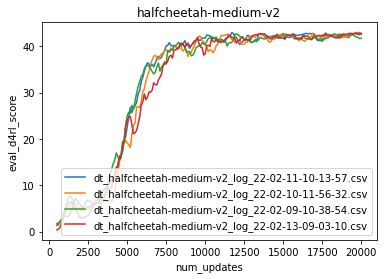

In [47]:
import numpy as np
import pickle

import pandas as pd
import glob

import matplotlib.pyplot as plt


env_d4rl_name = 'halfcheetah-medium-v2'

log_dir = 'dt_runs/'

x_key = "num_updates"
y_key = "eval_d4rl_score"
y_smoothing_win = 5
plot_avg = False
save_fig = False

if plot_avg:
    save_fig_path = env_d4rl_name + "_avg.jpg"
else:
    save_fig_path = env_d4rl_name + ".jpg"


all_files = glob.glob(log_dir + f'/dt_{env_d4rl_name}*.csv')

ax = plt.gca()
ax.set_title(env_d4rl_name)

if plot_avg:
    name_list = []
    df_list = []
    for filename in all_files:
        frame = pd.read_csv(filename, index_col=None, header=0)
        print(filename, frame.shape)
        frame['y_smooth'] = frame[y_key].rolling(window=y_smoothing_win).mean() 
        df_list.append(frame)
    
    
    df_concat = pd.concat(df_list)
    df_concat_groupby = df_concat.groupby(df_concat.index)
    data_avg = df_concat_groupby.mean()

    data_avg.plot(x=x_key, y='y_smooth', ax=ax)
    
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend(['avg of all runs'], loc='lower right')
    
    if save_fig:
        plt.savefig(save_fig_path)
        
    plt.show()
    
    
else:
    name_list = []
    for filename in all_files:
        frame = pd.read_csv(filename, index_col=None, header=0)
        print(filename, frame.shape)
        frame['y_smooth'] = frame[y_key].rolling(window=y_smoothing_win).mean()
        frame.plot(x=x_key, y='y_smooth', ax=ax)
        name_list.append(filename.split('/')[-1])
    
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend(name_list, loc='lower right')
    
    if save_fig:
        plt.savefig(save_fig_path)
    
    plt.show()
    
